# Loading the libs

In [1]:
import os
import numpy as np
import string
import pandas as pd
import math
import utils
import swifter
import operator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from copy import deepcopy

import sklearn
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Downloading nltk corpus

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/simon/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [5]:
stopword = set(stopwords.words('english'))
punctuat = set(string.punctuation)

In [6]:
data = utils.load_data()

In [7]:
data.iloc[2]

text    who would have thought  \njim carrey does dram...
type                                                  pos
Name: 2, dtype: object

In [8]:
def visualize(label):
  words = ''
  for msg in data[data['type'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

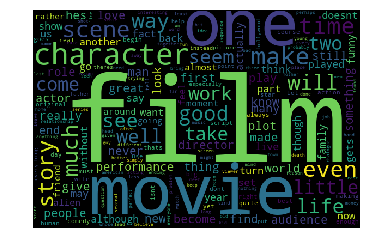

In [9]:
visualize('pos')

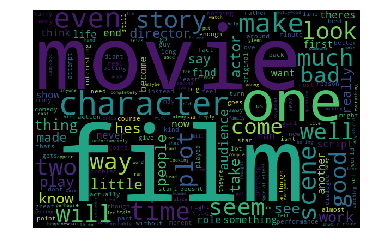

In [10]:
visualize('neg')

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

In [12]:
def get_score(index, score, matrix, order):
    X_ = matrix[index]
    indexes = (X_ >= score).nonzero()
    indexes[1].tolist()
    scores = []
    for value in indexes[1]:
        scores.append((vectorizer.get_feature_names()[value], matrix[index, value]))
    scores = sorted(scores, key=lambda tup: tup[1])
    if order == 'ascending':
        return scores
    elif order == 'descending':
        return scores[::-1]

In [13]:
get_score(2, 0.1, X, 'descending')

[('truman', 0.506393345166602),
 ('the', 0.3151491601181007),
 ('carrey', 0.24586981059643814),
 ('trumans', 0.1793122544076773),
 ('show', 0.1739811322549454),
 ('is', 0.1543812230155566),
 ('and', 0.1471431244999365),
 ('he', 0.13489526505635274),
 ('jim', 0.1343694549180274),
 ('world', 0.12612342533204338),
 ('of', 0.12612267814280273),
 ('it', 0.10851881334726159)]

In [14]:
threshold = np.linspace(start = 0.0, stop = 0.8, num = 10)
threshold

array([0.        , 0.08888889, 0.17777778, 0.26666667, 0.35555556,
       0.44444444, 0.53333333, 0.62222222, 0.71111111, 0.8       ])

In [15]:
# For each words, if the word is in the word dictionary that we have previously created, we keep it, discard it if not. 
WORD_DICT = vectorizer.get_feature_names()
def filter_words(s, X, threshold):
    words = []
    idf = X
    for w in s:
        if w in vectorizer.vocabulary_ and idf[0, vectorizer.vocabulary_[w]] > threshold:
            words.append(w)
    return words

In [16]:
def newData(thresholds, X):
    data = utils.load_data()
    data['idf'] = ''
    for i in data.index:
        data.loc[i]['idf'] = X[i] 
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
    # Tokenizing texts
    data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))
    # filtering word from the dictionary
    data['preprocess'] = data.apply(lambda x: filter_words(x['preprocess'], x['idf'], thresholds), axis=1)
    # Transforming array of string into a single string
    data['text'] = data['preprocess'].swifter.apply(lambda x : ' '.join(word for word in x))
    return data

In [17]:
def find_threshold(model, thresholds, X):
    test_accuracy = []
    train_accuracy = []
    for thresh in thresholds:
        data = newData(thresholds=thresh, X=X)
        newvectorizer = TfidfVectorizer()
        newX = newvectorizer.fit_transform(data['text'])
        newy = data['type'].as_matrix()
        X_train, X_test, y_train, y_test = train_test_split(newX, newy, test_size = 0.33)
        model.fit(X_train, y_train)
        print("threshold : {}".format(thresh))
        #print("Training accuracy : {}".format(model.score(X_train, y_train)))
        train_accuracy.append(model.score(X_train, y_train))
        #print("Test accuracy : {}".format(model.score(X_test, y_test)))
        test_accuracy.append(model.score(X_test, y_test))
        #print("Classification report for test set")
        #print(classification_report(y_test, model.predict(X_test)))
    return test_accuracy, train_accuracy

In [18]:
model = MultinomialNB()
ta, tra = find_threshold(model, threshold, X)

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 47698.05it/s]


threshold : 0.0


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 141630.08it/s]


threshold : 0.08888888888888889


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 300354.76it/s]


threshold : 0.17777777777777778


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 403803.22it/s]


threshold : 0.26666666666666666


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 443349.08it/s]


threshold : 0.35555555555555557


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 487653.06it/s]


threshold : 0.4444444444444445


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 524058.72it/s]


threshold : 0.5333333333333333


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 528416.25it/s]


threshold : 0.6222222222222222


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 554252.26it/s]


threshold : 0.7111111111111111


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 515650.85it/s]

threshold : 0.8


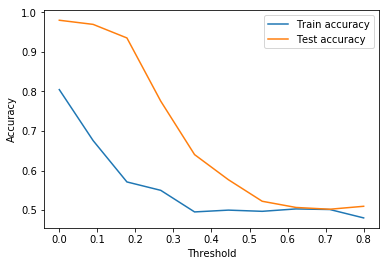

In [19]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
ta, tra = find_threshold(model, threshold, X)

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 48964.56it/s]


threshold : 0.0


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 142733.80it/s]


threshold : 0.08888888888888889


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 277888.10it/s]


threshold : 0.17777777777777778


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 357540.19it/s]


threshold : 0.26666666666666666


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 425234.86it/s]


threshold : 0.35555555555555557


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 499768.13it/s]


threshold : 0.4444444444444445


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 481771.65it/s]


threshold : 0.5333333333333333


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 507692.79it/s]


threshold : 0.6222222222222222


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 543831.96it/s]


threshold : 0.7111111111111111


Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 546916.68it/s]


threshold : 0.8


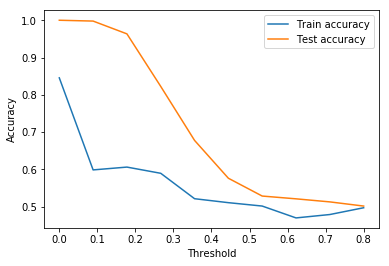

In [21]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that keeping all features perform better.

## Model Evaluation

### Kfolds - k = 10

In [22]:
utils.kfolds_tfidf(MultinomialNB(), data)

Train accuracy : 0.9648888888888889
Test accuracy : 0.8094999999999999
[0.82, 0.79, 0.8, 0.845, 0.77, 0.84, 0.805, 0.815, 0.77, 0.84]


In [23]:
utils.kfolds_tfidf(RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1), data)

Train accuracy : 1.0
Test accuracy : 0.8160000000000001
[0.86, 0.87, 0.87, 0.79, 0.82, 0.895, 0.78, 0.715, 0.79, 0.77]


### Confusion matrix

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [25]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
print("True Positive : {}, \t False Positive : {} \nTrue Negative : {}, \t False Negative : {}".format(tp, fp, tn, fn))

Training accuracy : 1.0
Test accuracy : 0.8136363636363636
Classification report for test set
              precision    recall  f1-score   support

         neg       0.78      0.86      0.82       326
         pos       0.85      0.77      0.81       334

   micro avg       0.81      0.81      0.81       660
   macro avg       0.82      0.81      0.81       660
weighted avg       0.82      0.81      0.81       660

True Positive : 256, 	 False Positive : 45 
True Negative : 281, 	 False Negative : 78


In [26]:
model = MultinomialNB()
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
print("True Positive : {}, \t False Positive : {} \nTrue Negative : {}, \t False Negative : {}".format(tp, fp, tn, fn))

Training accuracy : 0.9708955223880597
Test accuracy : 0.8318181818181818
Classification report for test set
              precision    recall  f1-score   support

         neg       0.77      0.93      0.85       326
         pos       0.91      0.74      0.82       334

   micro avg       0.83      0.83      0.83       660
   macro avg       0.84      0.83      0.83       660
weighted avg       0.85      0.83      0.83       660

True Positive : 246, 	 False Positive : 23 
True Negative : 303, 	 False Negative : 88


### Testing on new data

In [27]:
df = pd.read_csv("Our_Data/text.csv", index_col=0)

In [28]:
texts = df['text'].tolist()

In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X, y)
X_test = vectorizer.transform(texts)
print("Training accuracy : {}".format(model.score(X, y)))
df.assign(scores = model.predict(X_test))

Training accuracy : 1.0


,text,scores
id,,
1,About as exciting as a trip to Hogwarts's most...,pos
2,"More workmanlike than magical, 'Fantastic Beas...",pos
3,"Despite being light in the story department, T...",pos
4,With too much happening all at once and not en...,neg
5,Part Two of J.K. Rowling's latest franchise is...,pos
6,It's not only the film's boring lack of origin...,pos
7,It's always fun to decry a formulaic movie - e...,pos
8,Although 'Creed 2' doesn't have the same rousi...,pos
9,Merely adopting a formula is easy - that happe...,pos


In [30]:
model = MultinomialNB()
model.fit(X, y)
X_test = vectorizer.transform(texts)
print("Training accuracy : {}".format(model.score(X, y)))
df.assign(scores = model.predict(X_test))

Training accuracy : 0.96


,text,scores
id,,
1,About as exciting as a trip to Hogwarts's most...,neg
2,"More workmanlike than magical, 'Fantastic Beas...",pos
3,"Despite being light in the story department, T...",neg
4,With too much happening all at once and not en...,neg
5,Part Two of J.K. Rowling's latest franchise is...,pos
6,It's not only the film's boring lack of origin...,neg
7,It's always fun to decry a formulaic movie - e...,neg
8,Although 'Creed 2' doesn't have the same rousi...,pos
9,Merely adopting a formula is easy - that happe...,pos


In this case, Naïve-Bayes work a lot better than random forest classifier.

## Feature Selection with mutual information

In [32]:
data = utils.load_data()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

contigency = []
for text in data.iterrows():
    words_list = {}
    for word in vectorizer.get_feature_names():
        if word in text[1]['text']:
            words_list[word] = True
        else:
            words_list[word] = False
    contigency.append(words_list)
    
pos = pd.DataFrame(contigency[0:1000])
neg = pd.DataFrame(contigency[1000:2000])

In [33]:
pos.head()

,00,000,0009f,000acre,000aweek,000foot,000paltry,007,007esque,00s,...,zuko,zukovsky,zulu,zundel,zurgs,zweibel,zwick,zwicks,zwigoffs,zycie
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
def getWordContigency(word, pos, neg):
    a = pos[word].value_counts()
    if True not in a:
        a = a.append(pd.Series([0], index=[True]))
    elif False not in a:
        a = a.append(pd.Series([0], index=[False]))
    b = neg[word].value_counts()
    if True not in b:
        b = b.append(pd.Series([0], index=[True]))
    elif False not in b:
        b = b.append(pd.Series([0], index=[False]))
    return [[a[True], b[True]], [a[False], b[False]]]

In [35]:
def getProbaWord(word, pos, neg):
    a = pos[word].value_counts()
    if True not in a:
        a[True] = 0
    elif False not in a:
        a[False] = 0
    b = neg[word].value_counts()
    if True not in b:
        b[True] = 0
    elif False not in b:
        b[False] = 0
    return a[True] + b[True] / 2000

In [36]:
def mutualInfo(matrix):
    proba = [[]]
    I = 0
    proba_word = [(matrix[0][0] + matrix[0][1]) / 2000, 1 - (matrix[0][0] + matrix[0][1]) / 2000]
    for i in range(0, 2):
        for j in range(0, 2):
            p = matrix[i][j] / 2000
            if math.isclose(p, 0, rel_tol = 1e-09):
                continue
            I += p * math.log2(p / (proba_word[i] * 1/2))
    return I

In [37]:
MI = {}
for word in vectorizer.get_feature_names():
    matrix = getWordContigency(word, pos, neg)
    MI[word] = mutualInfo(matrix)

Sorting all the word according to mutual information and taking the 2000 that have the biggest mutual information

In [38]:
sorted_x = sorted(MI.items(), key=operator.itemgetter(1))
WORD_DICT = [w[0] for w in sorted_x[-4001:-1]]

In [39]:
sorted_x[-11:-1]

[('perf', 0.02274386861093767),
 ('wasted', 0.02276228667162127),
 ('portray', 0.02290039412608253),
 ('ridiculous', 0.02587438074216572),
 ('wonderful', 0.02658110273988274),
 ('perfect', 0.026780079764826936),
 ('boring', 0.027258144339792185),
 ('stupid', 0.04044013799606765),
 ('worst', 0.04142695912121084),
 ('waste', 0.04479786552470821)]

In [40]:
data.head()

,text,type
0,bob the happy bastards quickie review \nthe m...,pos
1,today war became a reality to me after seeing...,pos
2,who would have thought \njim carrey does dram...,pos
3,crazybeautiful suffers from the damnedifyou...,pos
4,well this is not mission difficult mr hun...,pos


In [41]:
# For each words, if the word is in the word dictionary that we have previously created, we keep it, discard it if not. 
def filter_words(s):
    words = []
    for w in s:
        if w in WORD_DICT:
            words.append(w)
    return words

In [42]:
data = utils.load_data()
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
# Tokenizing texts
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))
# filtering word from the dictionary
data['preprocess'] = data['preprocess'].swifter.apply(lambda x: filter_words(x))
# Transforming array of string into a single string
data['text'] = data['preprocess'].swifter.apply(lambda x : ' '.join(word for word in x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 76957.59it/s]


In [43]:
model = MultinomialNB()
utils.kfolds_tfidf(model, data)

Train accuracy : 0.9416666666666667
Test accuracy : 0.8985000000000001
[0.85, 0.91, 0.91, 0.9, 0.91, 0.89, 0.895, 0.9, 0.93, 0.89]


In [44]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
utils.kfolds_tfidf(model, data)

Train accuracy : 1.0
Test accuracy : 0.8455
[0.865, 0.805, 0.85, 0.865, 0.83, 0.855, 0.845, 0.845, 0.835, 0.86]


# Extra POS tagging

In [45]:
from nltk import pos_tag

In [46]:
data = utils.load_data()
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 2858.49it/s]


In [47]:
data['pos'] = data['preprocess'].swifter.apply(lambda x: pos_tag(x))
data['pos'] = data['pos'].swifter.apply(lambda x: [w[1] for w in x])
data['fd'] = data['pos'].swifter.apply(lambda x: nltk.FreqDist(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 5580.81it/s]


In [48]:
data.head()

,text,type,preprocess,pos,fd
0,bob the happy bastards quickie review \nthe m...,pos,"[bob, happy, bastards, quickie, review, mummy,...","[NN, JJ, NNS, NN, NN, NN, NN, NNS, VBD, JJ, NN...","{'NN': 68, 'JJ': 41, 'NNS': 22, 'VBD': 4, 'RBR..."
1,today war became a reality to me after seeing...,pos,"[today, war, reality, seeing, screening, savin...","[NN, NN, NN, VBG, VBG, VBG, NN, NN, VBP, NN, V...","{'NN': 43, 'VBG': 7, 'VBP': 6, 'VBZ': 2, 'JJS'..."
2,who would have thought \njim carrey does dram...,pos,"[thought, jim, carrey, drama, saw, advertiseme...","[VBN, NNS, JJ, NN, VBD, JJ, NN, VBD, JJ, NN, N...","{'VBN': 6, 'NNS': 40, 'JJ': 59, 'NN': 114, 'VB..."
3,crazybeautiful suffers from the damnedifyou...,pos,"[crazybeautiful, suffers, damnedifyoudo, damne...","[JJ, NNS, VBP, JJ, JJ, NN, NN, NN, JJ, NNS, JJ...","{'JJ': 62, 'NNS': 41, 'VBP': 15, 'NN': 97, 'VB..."
4,well this is not mission difficult mr hun...,pos,"[mission, difficult, mr, hunt, mission, imposs...","[NN, JJ, NN, NN, NN, JJ, JJ, NN, NN, NN, NN, N...","{'NN': 137, 'JJ': 69, 'VBZ': 16, 'VBD': 10, 'V..."


In [49]:
POS_set = set()
for row in data.iterrows():
    for tag in row[1]['pos']:
        POS_set.add(tag)

In [50]:
def updateSet(x):
    for tag in POS_set:
        if not tag in x:
            x[tag] = 0
    tab = [x[tag] for tag in sorted(POS_set)]
    return tab

In [51]:
data['fd'] = data['fd'].swifter.apply(lambda x: updateSet(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 68215.04it/s]


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [53]:
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
utils.kflods_pos(model, data)

Train accuracy : 0.5979444444444444
Test accuracy : 0.5275000000000001
[0.595, 0.53, 0.46, 0.55, 0.51, 0.455, 0.57, 0.53, 0.545, 0.53]


In [54]:
model = MultinomialNB()
utils.kflods_pos(model, data)

Train accuracy : 0.5966666666666667
Test accuracy : 0.5690000000000001
[0.555, 0.56, 0.55, 0.565, 0.51, 0.57, 0.6, 0.6, 0.605, 0.575]


In [55]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10), random_state=1)
utils.kflods_pos(model, data)

Train accuracy : 0.6098333333333332
Test accuracy : 0.5940000000000001
[0.575, 0.615, 0.595, 0.595, 0.555, 0.555, 0.625, 0.605, 0.565, 0.655]


In [56]:
contigency = []
for text in data.iterrows():
    words_list = {}
    for tag in POS_set:
        if tag in text[1]['pos']:
            words_list[tag] = True
        else:
            words_list[tag] = False
    contigency.append(words_list)

In [57]:
def getWordContigency(tag, pos, neg):
    a = pos[tag].value_counts()
    if True not in a:
        a = a.append(pd.Series([0], index=[True]))
    elif False not in a:
        a = a.append(pd.Series([0], index=[False]))
    b = neg[tag].value_counts()
    if True not in b:
        b = b.append(pd.Series([0], index=[True]))
    elif False not in b:
        b = b.append(pd.Series([0], index=[False]))
    return [[a[True], b[True]], [a[False], b[False]]]

In [58]:
def mutualInfo(matrix):
    proba = [[]]
    I = 0
    proba_word = [(matrix[0][0] + matrix[0][1]) / 2000, 1 - (matrix[0][0] + matrix[0][1]) / 2000]
    for i in range(0, 2):
        for j in range(0, 2):
            p = matrix[i][j] / 2000
            if math.isclose(p, 0, rel_tol = 1e-09):
                continue
            I += p * math.log2(p / (proba_word[i] * 1/2))
    return I

In [59]:
pos = pd.DataFrame(contigency[0:1000])
neg = pd.DataFrame(contigency[1000:2000])

In [60]:
MI = {}
for tag in POS_set:
    matrix = getWordContigency(tag, pos, neg)
    MI[tag] = mutualInfo(matrix)

In [61]:
sorted_x = sorted(MI.items(), key=operator.itemgetter(1))

In [62]:
sorted_x

[('RB', -1.2813706015259676e-18),
 ('SYM', 0.0),
 ('NNS', 0.0),
 ('NN', 0.0),
 ('EX', 0.0),
 ('VBG', 0.0),
 ('JJ', 0.0),
 ('PRP', 4.533717028935228e-06),
 ('WDT', 1.0489916067016433e-05),
 ('CD', 1.7154311217477047e-05),
 ('JJR', 2.6798812094052347e-05),
 ('CC', 4.159577174267146e-05),
 ('RP', 6.729483782431673e-05),
 ('RBR', 8.792009740304311e-05),
 ('IN', 0.00010535036955963001),
 ('VBD', 0.00012273685671753066),
 ('PRP$', 0.00015508561070772062),
 ('WRB', 0.0002584822947280527),
 ('NNP', 0.0002964800438240503),
 ('VBN', 0.0003404627467939632),
 ('WP', 0.00043973774415648854),
 ('TO', 0.00048070674311640155),
 ('VBZ', 0.0004807067431164769),
 ("''", 0.0005001804271010232),
 ('JJS', 0.0005012921204565115),
 ('DT', 0.0006225288137355822),
 ('MD', 0.0006372792609078502),
 ('VBP', 0.0010007220697106993),
 ('VB', 0.0011033258571488194),
 ('UH', 0.0018524769246639943),
 ('FW', 0.0019442915712638495),
 ('POS', 0.0020028911743617357),
 ('NNPS', 0.0020028911743617357),
 ('PDT', 0.002504519726

In [63]:
top_set = [x[0] for x in sorted_x[-11:-1]]

In [64]:
top_set = set(top_set)

In [65]:
deleted_TAG = POS_set - top_set

In [66]:
top_set

{'DT', 'FW', 'JJS', 'MD', 'NNPS', 'PDT', 'POS', 'UH', 'VB', 'VBP'}

In [67]:
def updateSet(x):
    for tag in POS_set:
        if not tag in x:
            x[tag] = 0
    tab = [x[tag] for tag in sorted(top_set)]
    return tab

In [68]:
data = utils.load_data()
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

data['pos'] = data['preprocess'].swifter.apply(lambda x: pos_tag(x))
data['pos'] = data['pos'].swifter.apply(lambda x: [w[1] for w in x])
data['fd'] = data['pos'].swifter.apply(lambda x: nltk.FreqDist(x))

data['fd'] = data['fd'].swifter.apply(lambda x: updateSet(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 82295.31it/s]


In [69]:
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
utils.kflods_pos(model, data)

model = MultinomialNB()
utils.kflods_pos(model, data)

model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10), random_state=1)
utils.kflods_pos(model, data)

Train accuracy : 0.6002777777777778
Test accuracy : 0.514
[0.515, 0.535, 0.57, 0.55, 0.515, 0.525, 0.495, 0.495, 0.455, 0.485]
Train accuracy : 0.5295
Test accuracy : 0.5175
[0.525, 0.52, 0.46, 0.53, 0.505, 0.545, 0.51, 0.46, 0.57, 0.55]
Train accuracy : 0.5719999999999998
Test accuracy : 0.5325
[0.52, 0.59, 0.51, 0.545, 0.495, 0.55, 0.505, 0.545, 0.54, 0.525]


In [70]:
new = pd.read_csv('Our_Data/text.csv', index_col=0)

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
new['preprocess'] = new['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

new['pos'] = new['preprocess'].swifter.apply(lambda x: pos_tag(x))
new['pos'] = new['pos'].swifter.apply(lambda x: [w[1] for w in x])
new['fd'] = new['pos'].swifter.apply(lambda x: nltk.FreqDist(x))

new['fd'] = new['fd'].swifter.apply(lambda x: updateSet(x))

Pandas Apply: 100%|██████████| 15/15 [00:00<00:00, 29648.71it/s]


In [71]:
new

,text,preprocess,pos,fd
id,,,,
1,About as exciting as a trip to Hogwarts's most...,"[exciting, trip, hogwarts, s, neglected, lavat...","[VBG, NN, NNS, RB, VBD, NN]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"More workmanlike than magical, 'Fantastic Beas...","[workmanlike, magical, fantastic, beasts, crim...","[JJ, JJ, JJ, NNS, NNS, VBP, NNS, IN, NN, NN, V...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,"Despite being light in the story department, T...","[despite, light, story, department, crimes, gr...","[IN, JJ, NN, NN, NNS, VBP, NNS, RB, JJ, NNS, V...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,With too much happening all at once and not en...,"[happening, focus, bulding, characters, actual...","[VBG, NN, VBG, NNS, RB, VB, NN, NNS, VBP, JJ, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
5,Part Two of J.K. Rowling's latest franchise is...,"[j, k, rowling, s, latest, franchise, bewilder...","[NN, NN, VBG, JJ, JJS, NN, VBG, JJR, JJ, NN, R...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
6,It's not only the film's boring lack of origin...,"[s, film, s, boring, lack, originality, respec...","[NN, NN, NN, VBG, NN, NN, VBP, JJ, JJ, NN, IN,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
7,It's always fun to decry a formulaic movie - e...,"[s, fun, decry, formulaic, movie, formula, act...","[NN, NN, NN, JJ, NN, NN, RB, VBZ]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,Although 'Creed 2' doesn't have the same rousi...,"[creed, t, rousing, magic, chapter, offers, in...","[NN, NNS, VBG, JJ, NN, NNS, VBG, JJ, NNS, NNS,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,Merely adopting a formula is easy - that happe...,"[merely, adopting, formula, easy, happens, inv...","[RB, VBG, NN, JJ, VBZ, VBG, NN, VBG, JJ, JJ, N...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [72]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
model.fit(X_train, y_train)
model.predict(new['fd'].tolist())

array(['neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg'], dtype='<U3')